# Global Warming

---
Study made in October 2019.

This document shows basic filtering on global temperature to form my own opinion concerning the climate warming but also to check if the prediction of the GIEC is correct.

*Code is made in Julia and Markdown.*

---

First, we have to define some utility routines:

In [1]:
# Needed Julia packages:
#   DelimitedFiles: for readdlm() needed for importing data
#   Statistics: for mean()
#   FFTW: for fft()
#   DSP: for fftfreq()
#   Plots: for drawing data with plot()
using DelimitedFiles, Statistics, FFTW, DSP, Plots;

In [2]:
# Percent error between an exact and an approximate value
percent_error(approx, exact) = 100.0 * abs(approx - exact) / exact

percent_error (generic function with 1 method)

In [3]:
# Find the first max value and its index from a given array.
# Note: Quick & dirty algorithm: the array need to be filtered
# and we suppose a maximum is found within the range [s:e].
function findOptimum(A::Array{Float64}, s::Int64, e::Int64)
    i = s
    while (i < e) && (A[i] < A[i + 1]) 
        i = i + 1
    end
    return i, A[i]
end

findOptimum (generic function with 1 method)

In [4]:
# Constrain x between low and high
constrain(x, low, high) = (x < low) ? low : (x > high ? high : x)

# Convert a year to array index and constrain it inside the array range
y2i(A::Array, y::Int64) = constrain(1 + y - Int64(A[1]), 1, length(A))

y2i (generic function with 1 method)

In [5]:
# Filter function based on FFT
# r: range of frequencies we want to preserve:
#   preserve low +ve frequencies [1:r+1]
#   preserve low -ve frequencies [end-r+1:end]
# Unpreserved frequencies are zero'ed.
function filtFFT(S::Vector{Float64}, r::Int64)
    F = fft(S)
    F[r+1:end-r+1] .= 0.0
    real(ifft(F))
end

filtFFT (generic function with 1 method)

In [6]:
# The problem with filtering based on FFT is that on non continuous signal (such as
# at the begining and at the end of a set of data) the signal gets "curvy". To remove
# this side effect, two methods can be applied:
#  - remove to the signal its linear regression.
#  - remove to the signal the segment line passing from the begin and the end of the
#    plot. This method gives better result than linear regression.

# Linear regression
linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y

# Get the segment line passing from the begin and the end of a set of data.
function border2line(X::Vector{Int64}, Y::Vector{Float64}, step::Int64=1)
    y0 = Y[1]  
    dy = Y[end] - Y[1]
    dx = Float64(X[end] - X[1])
    m  = step * dy / dx
    
    l = length(Y)
    R = ones(l)
    for n = 1:l
        y0 += m
        R[n] = y0
    end
    R
end

border2line (generic function with 2 methods)

---
## HadCRUT4's temperature anomalies

[HadCRUT4](https://climatedataguide.ucar.edu/climate-data/global-surface-temperature-data-hadcrut4-and-crutem4)
is a combination of the global land surface temperature data set, CRUTEM4 and the global SST data set.

In [7]:
# HadCRUT4: matrix year-month of temperature anomalies since 1850
#  1st column = year
#  other colum = 12 temperature (one by month)
H = convert(Matrix{Float64}, readdlm("data/HadCRUT4.txt", ' ', Any, '\n'))

# Dh: years, Th: averaged temperature over each year. h: HadCRUT4
Dh, Th = convert(Vector{Int64}, H[:,1]), mean(H[:,2:end]; dims=2)[:]

# Add last point from UAH
Dh = [Dh; 2019]
Th = [Th; 0.69]

# Convert HadCRUT4 year to HadCRUT4 array index
yh2i(y::Int64) = y2i(Dh, y)

yh2i (generic function with 1 method)

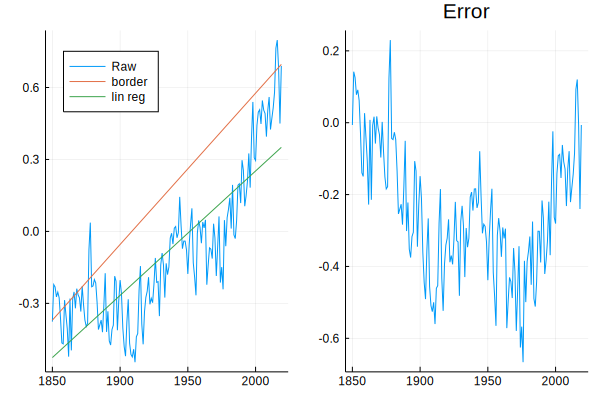

In [8]:
# Get the linear regression of temperatures over years
b, a = linreg(Dh, Th)
regression = a .* Dh .+ b

# Line passing by corners
regTh = border2line(Dh, Th)

plot(plot(Dh, [Th regTh regression], 
         label=["Raw" "border" "lin reg"], legend=:topleft),
     plot(Dh, Th .- regTh, title="Error", leg=false),
     layout=2)

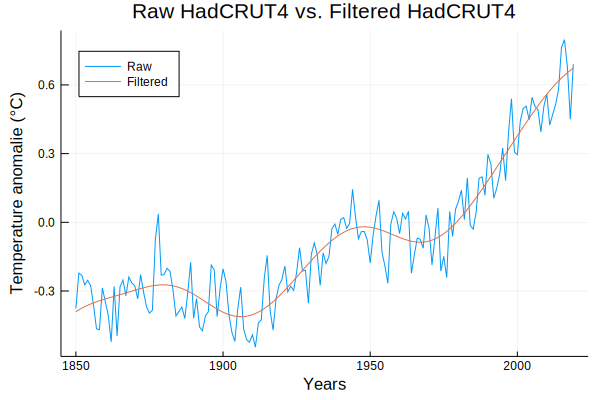

In [9]:
# Filter the raw signal minus its linear regression.
# Thf: HadCRUT4 filtered temperature.
Thf = filtFFT(Th .- regTh, 6) .+ regTh

plot(Dh, [Th Thf], title = "Raw HadCRUT4 vs. Filtered HadCRUT4",
                   xlabel="Years", ylabel="Temperature anomalie (°C)", 
                   label=["Raw" "Filtered"], legend=:topleft)

Note the peak at 2015 -- 2016 implied by El Niño.

---
## Personal Temperature Prediction

Here is our personal temperature prediction for years ~2100. This model is only based on filtered HadCRUT4 values.

First, since year 1850, we notice 3 cycles where the temperature is at optimum:
- 1st cycle at around year 1880
- 2nd cycle at around year 1950
- 3th cycle at around year 2016

Here a function to find more precisely dates and temperatures:

In [10]:
i1, Tc1 = findOptimum(Thf, yh2i(1870), yh2i(1890))
i2, Tc2 = findOptimum(Thf, yh2i(1940), yh2i(1955))
i3, Tc3 = findOptimum(Thf, yh2i(2000), yh2i(Dh[end]))
y1, y2, y3 = Dh[i1], Dh[i2], Dh[i3]

[y1 y2 y3], [Tc1 Tc2 Tc3]

([1880 1948 2019], [-0.273096 -0.0196047 0.673217])

These cycles seem to be periodic (~70 years):

In [11]:
y2 - y1, y3 - y2, "years"

(68, 71, "years")

Estimated year for the next optimum cycle (~2100):

In [12]:
y4 = y3 + (y2 - y1 + y3 - y2) ÷ 2

2088

Second, let suppose a new cycle will apear on years in years ~2100. Let also suppose:
- the temperature raise is mainly due by the human kind;
- the economy and energy consumption of human kind will keep increasing with the same current **exponential** rate. Some informal values showing the exponential rate:
  - 1850: 1.4 billion humans World energy consumption: 20 exajoules.
  - 1950: 2.5 billion humans. World energy consumption: 100 exajoules.
  - 2019: 7.5 billion. World energy consumption: 500 exajoules.
  - 2100: >16 billion. World energy consumption: >2000 exajoules.

Therefore, with an exponential rate, the ratio of the amplitude between the third cycle (year 2016) and the second cycle (year 1950) will the same than the second cycle and the first (year 1880). We can estimate the temperature (°C) for ~2090:

In [13]:
Tc32 = Tc3 - Tc2                # Delta temperature between third cycle and second cycle
Tc21 = Tc2 - Tc1                # Delta temperature between second cycle and first cycle
EstimTh = Tc32 * (Tc32 / Tc21)  # Estimated temperature (exponential rate)

1.8935649797574394

The temperature anomalie will be around +1.8°C and we are based on the worst scenario which seems not possible (See World3 on Wikipedia or this [World3 simulation](https://insightmaker.com/insight/1954/The-World3-Model-A-Detailed-World-Forecaster) the population will probably decline due to limited and quantity of natural resources).

---
## UAH satellite temperature dataset

https://www.drroyspencer.com/latest-global-temperatures/

In [14]:
# Extract UAH data sate (U: for UAH).
U = convert(Matrix{Float64}, readdlm("data/uah.txt", ' ', Any, '\n'));

# D: years, T: temperature. u: UAH
Du = [convert(Vector{Int64}, U[:,1])[2:12:482];]
Tu_ = zeros(Float64, 41,12)
Tu_[:,1] = U[2:12:482,3]
Tu_[:,2] = U[3:12:483,3]
Tu_[:,3] = U[4:12:484,3]
Tu_[:,4] = U[5:12:485,3]
Tu_[:,5] = U[6:12:486,3]
Tu_[:,6] = U[7:12:487,3]
Tu_[:,7] = U[2:12:488,3]
Tu_[:,8] = U[3:12:489,3]
Tu_[:,9] = U[4:12:490,3]
Tu_[:,10] = U[5:12:491,3]
Tu_[:,11] = U[6:12:492,3]
Tu_[:,12] = U[7:12:493,3]
Tu = mean(Tu_,dims=2)[:]

# Convert UAH year to UAH array index
yu2i(y::Int64) = y2i(Du, y)

yu2i (generic function with 1 method)

In [15]:
regTu = border2line(Du, Tu);

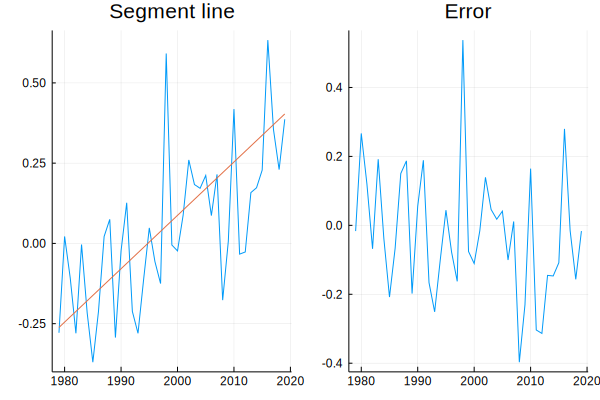

In [16]:
plot(plot(Du, [Tu regTu], title="Segment line", leg=false),
     plot(Du, Tu .- regTu, title="Error", leg=false),
     layout=2)

In [17]:
Toff = mean(Th[yh2i(1980):yh2i(2018)]) - mean(Tu[yu2i(1980):yu2i(2018)])
Tu = Tu .+ Toff;
Toff

0.30344707429322815

In [18]:
# Missing temperature for HadCRUT4
Tu[end]

0.6901137409598948

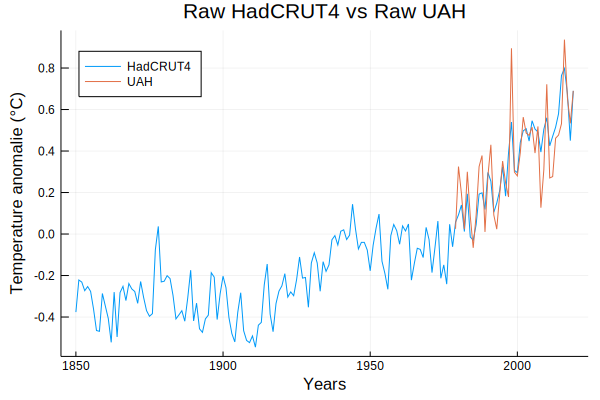

In [19]:
plot(Dh, Th, title = "Raw HadCRUT4 vs Raw UAH", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)
plot!(Du, Tu, label="UAH")

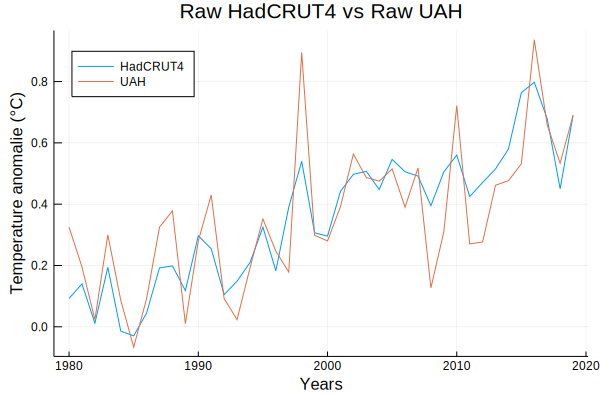

In [20]:
plot(Dh[yh2i(1980):yh2i(2019)], Th[yh2i(1980):yh2i(2019)], title = "Raw HadCRUT4 vs Raw UAH", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)
plot!(Du[yu2i(1980):yu2i(2019)], Tu[yu2i(1980):yu2i(2019)], label="UAH")

---
## GIEC's AR5 Model

Let compare the GIEC model with observed HadCRUT4 temperature.

In [21]:
# Extract GIEC data sate (G: for GIEC).
G = convert(Matrix{Float64}, readdlm("data/AR5.txt", ' ', Any, '\n'));

# We halt the GIEC's model to Year 2020 because after the model is purely linear
# and our study is made in 2019.
Dend = Int64(2020 - G[1,1])

# D: years, T: temperature. g: GIEC
Dg, Tg = convert(Vector{Int64}, G[1:Dend,1]), G[1:Dend,2]

# Convert GIEC year to GIEC array index
yg2i(y::Int64) = y2i(G[:,1], y)

yg2i (generic function with 1 method)

In [22]:
# Offset (°C) between GIEC values and HadCRUT4 values.
# To find the offset, we average temperature on years [1980:2010]
# because AR5 was made on 2013 and model follows years 2000.
Toff = mean(Th[yh2i(1980):yh2i(2010)]) - mean(Tg[yg2i(1980):yg2i(2010)])
Tg = Tg .+ Toff;
Toff

0.5203361248138958

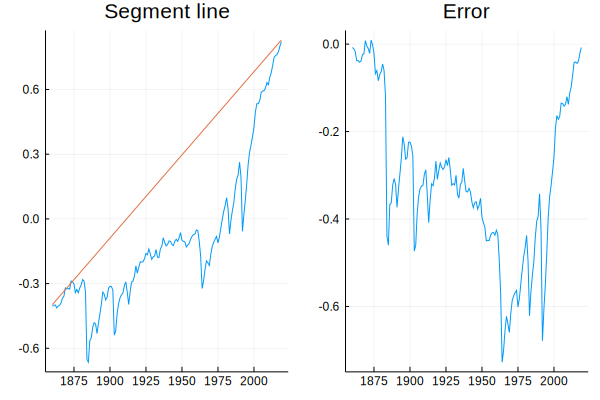

In [23]:
# Get the linear regression of GIEC temperature model over years
#b, a = linreg(Dg, Tg)
#regTg = a .* Dg .+ b
regTg = border2line(Dg, Tg)

plot(plot(Dg, [Tg regTg], title="Segment line", leg=false),
     plot(Dg, Tg .- regTg, title="Error", leg=false),
     layout=2)

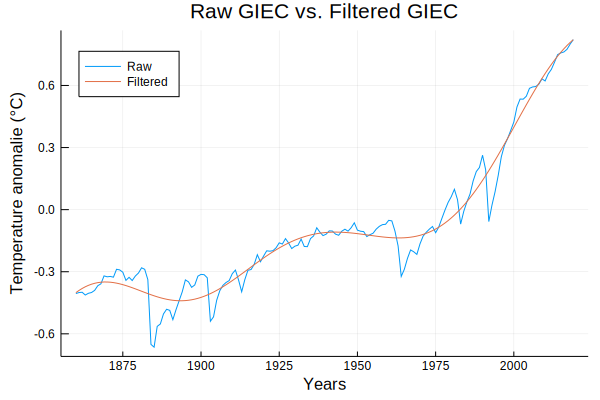

In [24]:
# Filtered GIEC model
Tgf = filtFFT(Tg .- regTg, 4) .+ regTg

plot(Dg, Tg, title="Raw GIEC vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Raw", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

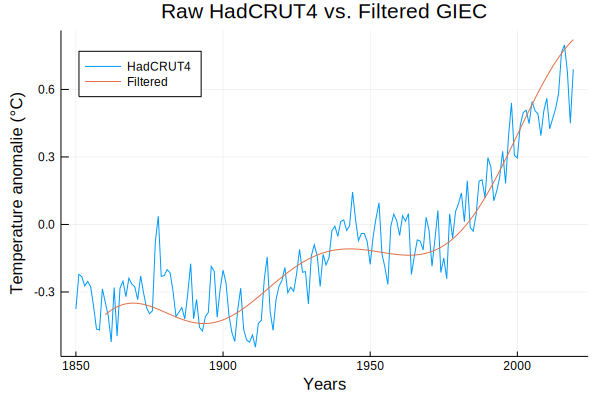

In [25]:
plot(Dh, Th, title="Raw HadCRUT4 vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

GIEC model, at first sight, seems to be good because the filtered curve crosses the El Niño in 2016 but at second sight, the AR5 model was made in 2013 and therefore before El Niño which does not appear on their raw data.

When comparing filtered AR5 model with filtered HadCRUT4 we can notice that GIEC model does not fit with filtered observations before years 2000 and the rate of the slope is to sharp after years 2000.

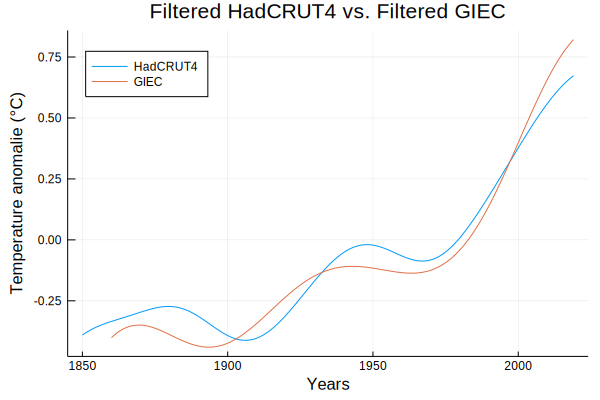

In [26]:
# Filtered GIEC model versus filtered HadCRUT4
plot(Dh, Thf, title="Filtered HadCRUT4 vs. Filtered GIEC",
              xlabel="Years", ylabel="Temperature anomalie (°C)", 
              label="HadCRUT4", legend=:topleft)

plot!(Dg, Tgf, label="GIEC")

## Error of GIEC model

In [27]:
y3, percent_error(Tgf[yg2i(y3)], Thf[yh2i(y3)])

(2019, 21.986436025834976)

Estimated Temperature (°C) for the next optimum cycle:

In [28]:
Y, EstimTg = y4, G[yg2i(y4),2] - Toff

(2088, 1.4051138751861043)

GIEC model error compared to temperature HadCRUT4 based model:

In [29]:
percent_error(EstimTg, EstimTh)

25.795317815494478

---
## Ljungqvist's Temperature Reconstruction

Let check if the 70-year oscillation is still present in early ages of humanity.

In [30]:
# Ljungqvist dataset:
#   1st column: temporal slice (ie 09 means from year to year 9).
#   2nd column: averaged temperature over 10 years (from year 0 to 2000).
L = convert(Matrix{Float64}, readdlm("data/ljung.txt", ' ', Any, '\n'));
Dl = convert(Vector{Int64}, [1:size(L,1);]) .* 10
Tl = L[:,2];

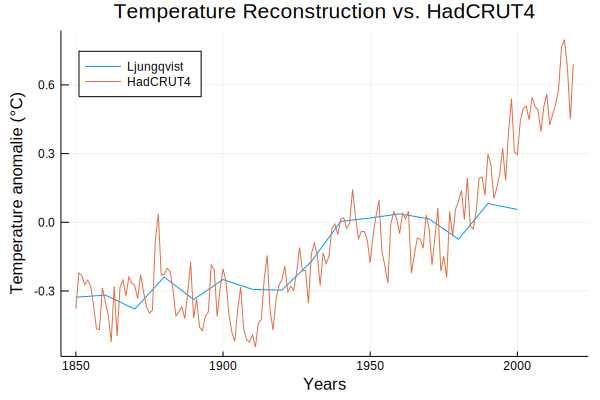

In [31]:
plot(Dl[185:end], Tl[185:end],
    title="Temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

Complete Ljungqvist missing temperatures (year 2000 -- 2019) with HadCRUT4 values.

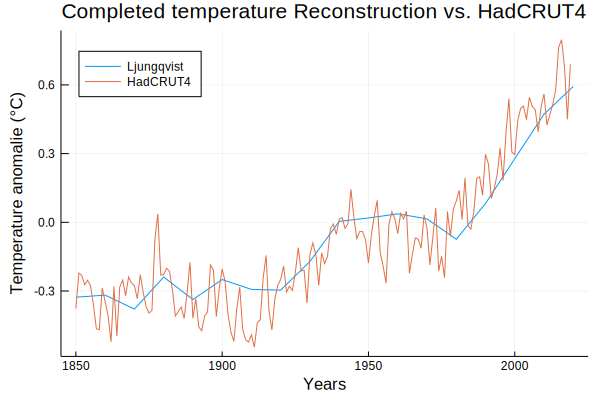

In [32]:
# Recompute the temperature on decade 1990--2000 because it looks wrong
Tl[end] = mean(Th[yh2i(1990):yh2i(2000)])

# Complete data with the two last decades
Dl = [Dl; 2010; 2020]
Tl = [Tl; mean(Th[yh2i(2000):yh2i(2010)]);
          mean(Th[yh2i(2010):yh2i(Dh[end])])]

plot(Dl[185:end], Tl[185:end],
    title="Completed temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

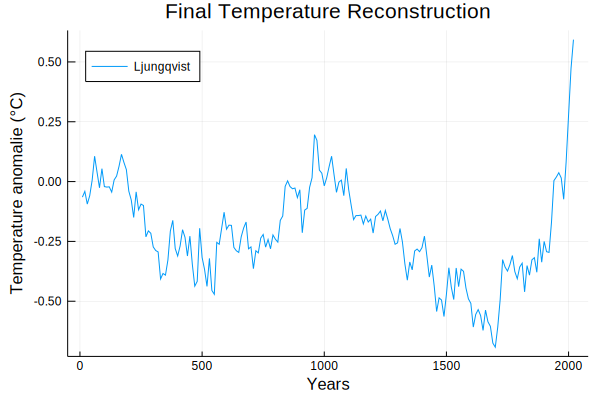

In [33]:
plot(Dl, Tl, title="Final Temperature Reconstruction", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Ljungqvist", legend=:topleft)

In years 1700 seems to be the coldest moment over this last 2000 years. Let zoom it. For curiosity I marked some important dates such as Industrial Revolutions (IR).

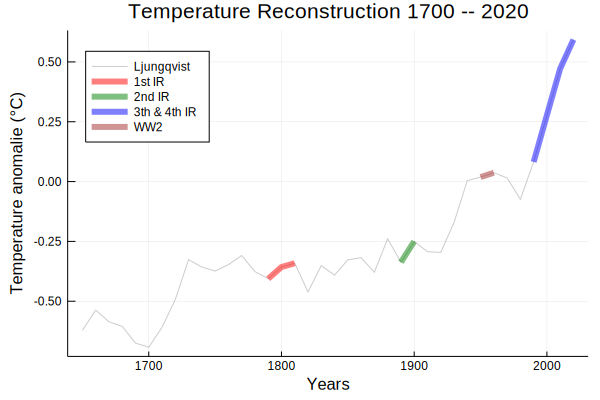

In [34]:
plot(Dl[165:end], Tl[165:end], 
    title="Temperature Reconstruction 1700 -- 2020", 
    xlabel="Years", ylabel="Temperature anomalie (°C)", line=(:black, 0.2, 1, :solid), 
    label="Ljungqvist", legend=:topleft)
plot!(Dl[179:181], Tl[179:181], line=(:red, 0.5, 6, :solid), label="1st IR")
plot!(Dl[189:190], Tl[189:190], line=(:green, 0.5, 6, :solid), label="2nd IR")
plot!(Dl[199:end], Tl[199:end], line=(:blue, 0.5, 6, :solid), label="3th & 4th IR")
plot!(Dl[195:196], Tl[195:196], line=(:brown, 0.5, 6, :solid), label="WW2")

Industrial Revolutions seems to have no impact:
- First Industrial Revolution: 1780 -- 1810
- Second Industrial Revolution: 1880 -- 1900
- Third and fourth Industrial Revolution: > 1980

## Slopes of years 1700, 1920 and 2000

have the same rate:

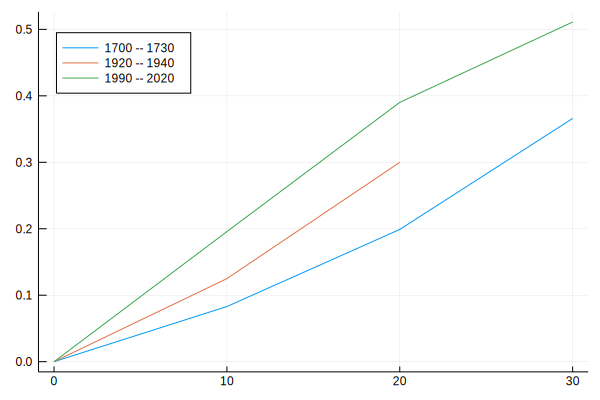

In [35]:
plot(Dl[170:173] .- 1700, Tl[170:173] .- Tl[170], label="1700 -- 1730", legend=:topleft)
plot!(Dl[192:194] .- 1920, Tl[192:194] .- Tl[192], label="1920 -- 1940")
plot!(Dl[199:end] .- 1990, Tl[199:end] .- Tl[199], label="1990 -- 2020")

### 1000-year cycle

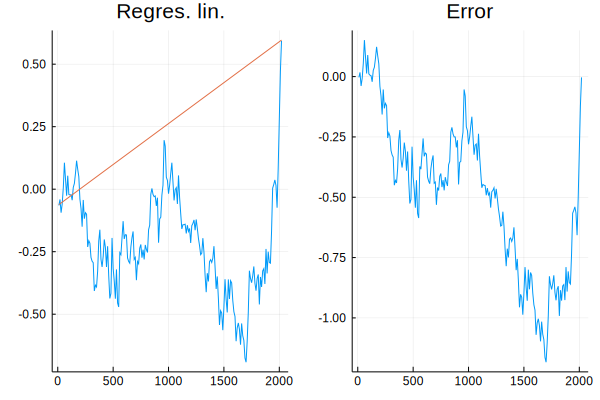

In [36]:
# Get the linear regression of Ljungqvist temperature model over years
#b, a = linreg(Dl, Tl)
#regTl = a .* Dl .+ b
regTl = border2line(Dl, Tl, 10)

plot(plot(Dl, [Tl regTl], title="Regres. lin.", leg=false),
     plot(Dl, Tl .- regTl, title="Error", leg=false),
     layout=2)

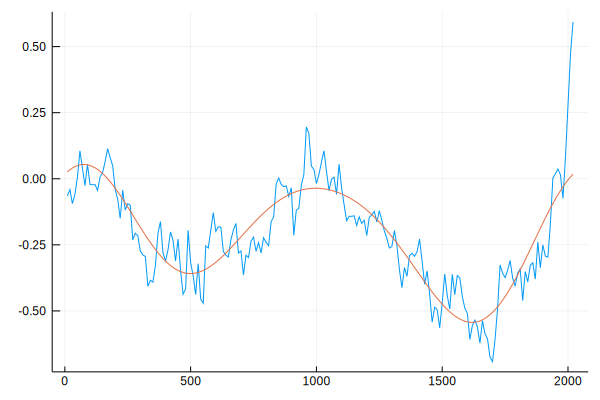

In [37]:
Tlf1000 = filtFFT(Tl, 4)
plot(Dl, [Tl Tlf1000], leg=false)

### 200-year cycle

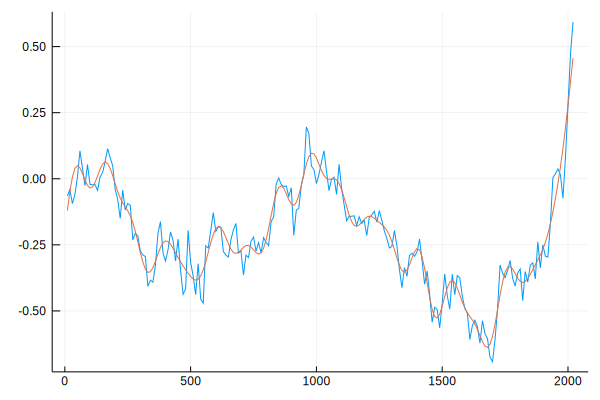

In [38]:
Tlf200 = filtFFT(Tl .- regTl, 20) .+ regTl
plot(Dl, [Tl Tlf200], leg=false)

### 70-year cycle

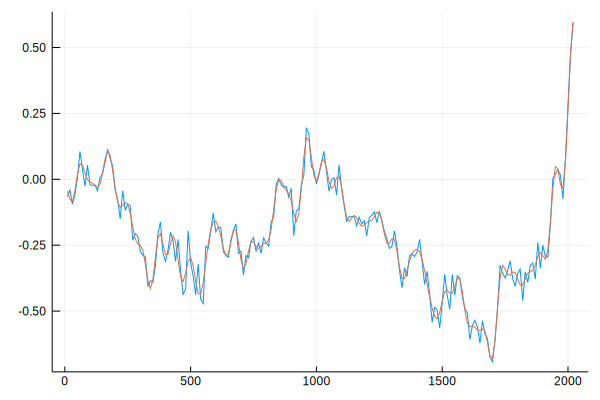

In [39]:
Tlf70 = filtFFT(Tl.- regTl, 40) .+ regTl
plot(Dl, [Tl Tlf70], leg=false)

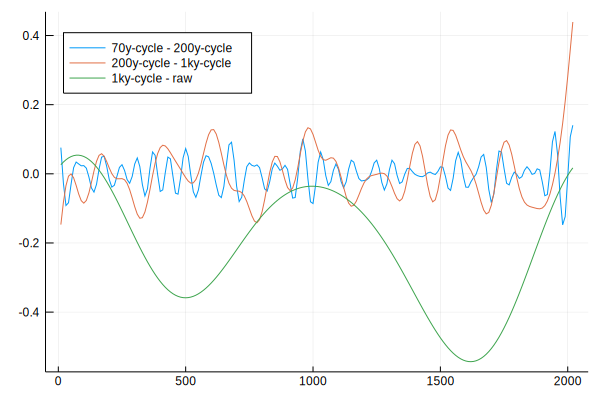

In [40]:
A = Tlf70 - Tlf200
B = Tlf200 - Tlf1000
C = Tlf1000

plot(Dl,  A, label="70y-cycle - 200y-cycle", legend=:topleft)
plot!(Dl, B, label="200y-cycle - 1ky-cycle")
plot!(Dl, C, label="1ky-cycle - raw")

## Are we on the max of 3 cycles?

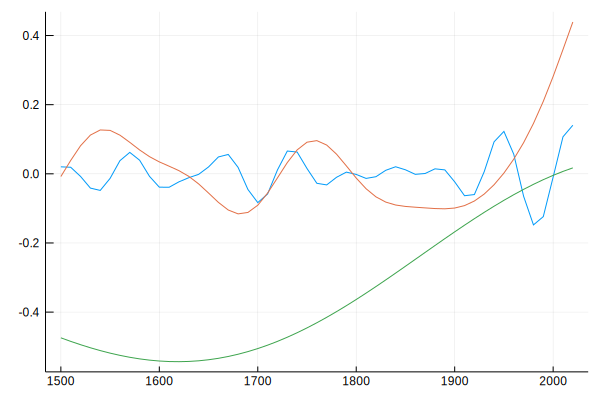

In [41]:
plot(Dl[150:end], A[150:end], leg=false)
plot!(Dl[150:end], B[150:end], leg=false)
plot!(Dl[150:end], C[150:end], leg=false)